QFT and Draper adder for performing the additions
Use of Grover search for identifing the matching subsets

Set of numbers under investigation: [5,7,8,9,1], find which of them add up to 16

In [442]:
# make the necessary imports
import matplotlib as plt
import numpy as np
from numpy import pi
from qiskit import *
import math
from qiskit import Aer
from qiskit.tools.visualization import plot_histogram
from qiskit.circuit.library import QFT

In [443]:
# Create the circuit, it should have total 31 qubits
# 5 (index) + 5 * 2 (for the 5-bit string numbers, the last 5 will be used for the addition the 1st 5 will be for the numbers representation with reseting each time we perform an addition)
#  + 1 which will be initialised in state |-> which will be used in Grover search
circuit = QuantumCircuit(16, 16)

# put index qubits in superposition to be able to represent all possible indeces in a supposed qRAM
circuit.h([0, 1, 2, 3, 4])

# put last qubit in state |->
circuit.x(15)
circuit.h(15)

In [444]:
# rotation function needed in draper adder
def rotation(circuit, phase, control_qubit, target_qubit): 
    circuit.cp(2 * pi / 2**(phase), control_qubit, target_qubit)

# define the draper adder function
def draper_adder_2_nums(num_qubits) :
    circuit = QuantumCircuit(num_qubits)

    for target_qubit in range(num_qubits - 1, num_qubits // 2 - 1, -1) :
        phase_index = 1
        for control_qubit in range(num_qubits -1 - target_qubit, -1, -1) :
            rotation(circuit, phase_index, control_qubit, target_qubit)
            phase_index += 1
        
    return circuit

In [445]:
# add 1st number 5: 00101 in the qubits 10 - 14
circuit.cnot(0, 10)
circuit.cnot(0, 12)

In [446]:
# then we perform the QFT in the last number of the 5 qubits 25 - 29
circuit.compose(QFT(5, do_swaps = True, name = 'qft'), qubits = [10, 11, 12, 13, 14], inplace = True)

circuit.barrier()

# continue with the other additions

# 2d number is 7: 00111
circuit.reset(range(5, 10))
circuit.cnot(1, 5)
circuit.cnot(1, 6)
circuit.cnot(1, 7)

# Perform Adder
circuit.compose(draper_adder_2_nums(10).to_gate(label='Adder'), inplace = True, qubits = range(5, 15))

# 3d number is 8: 01000
circuit.reset(range(5, 10))
circuit.cnot(2, 8)

# Perform Adder
circuit.compose(draper_adder_2_nums(10).to_gate(label='Adder'), inplace = True, qubits = range(5, 15))

# 4th number is 9: 01001 
circuit.reset(range(5, 10))
circuit.cnot(3, 5)
circuit.cnot(3, 8)

# Perform Adder
circuit.compose(draper_adder_2_nums(10).to_gate(label='Adder'), inplace = True, qubits = range(5, 15))

# 5th number is 1: 00001
circuit.reset(range(5, 10))
circuit.cnot(4, 5)

# Perform Adder
circuit.compose(draper_adder_2_nums(10).to_gate(label='Adder'), inplace = True, qubits = range(5, 15))

# Apply inverse QFT to get the addition
circuit.compose(QFT(5, do_swaps = True, inverse=True, name='qft_dagger'), qubits = [10, 11, 12, 13, 14], inplace = True)

circuit.barrier()

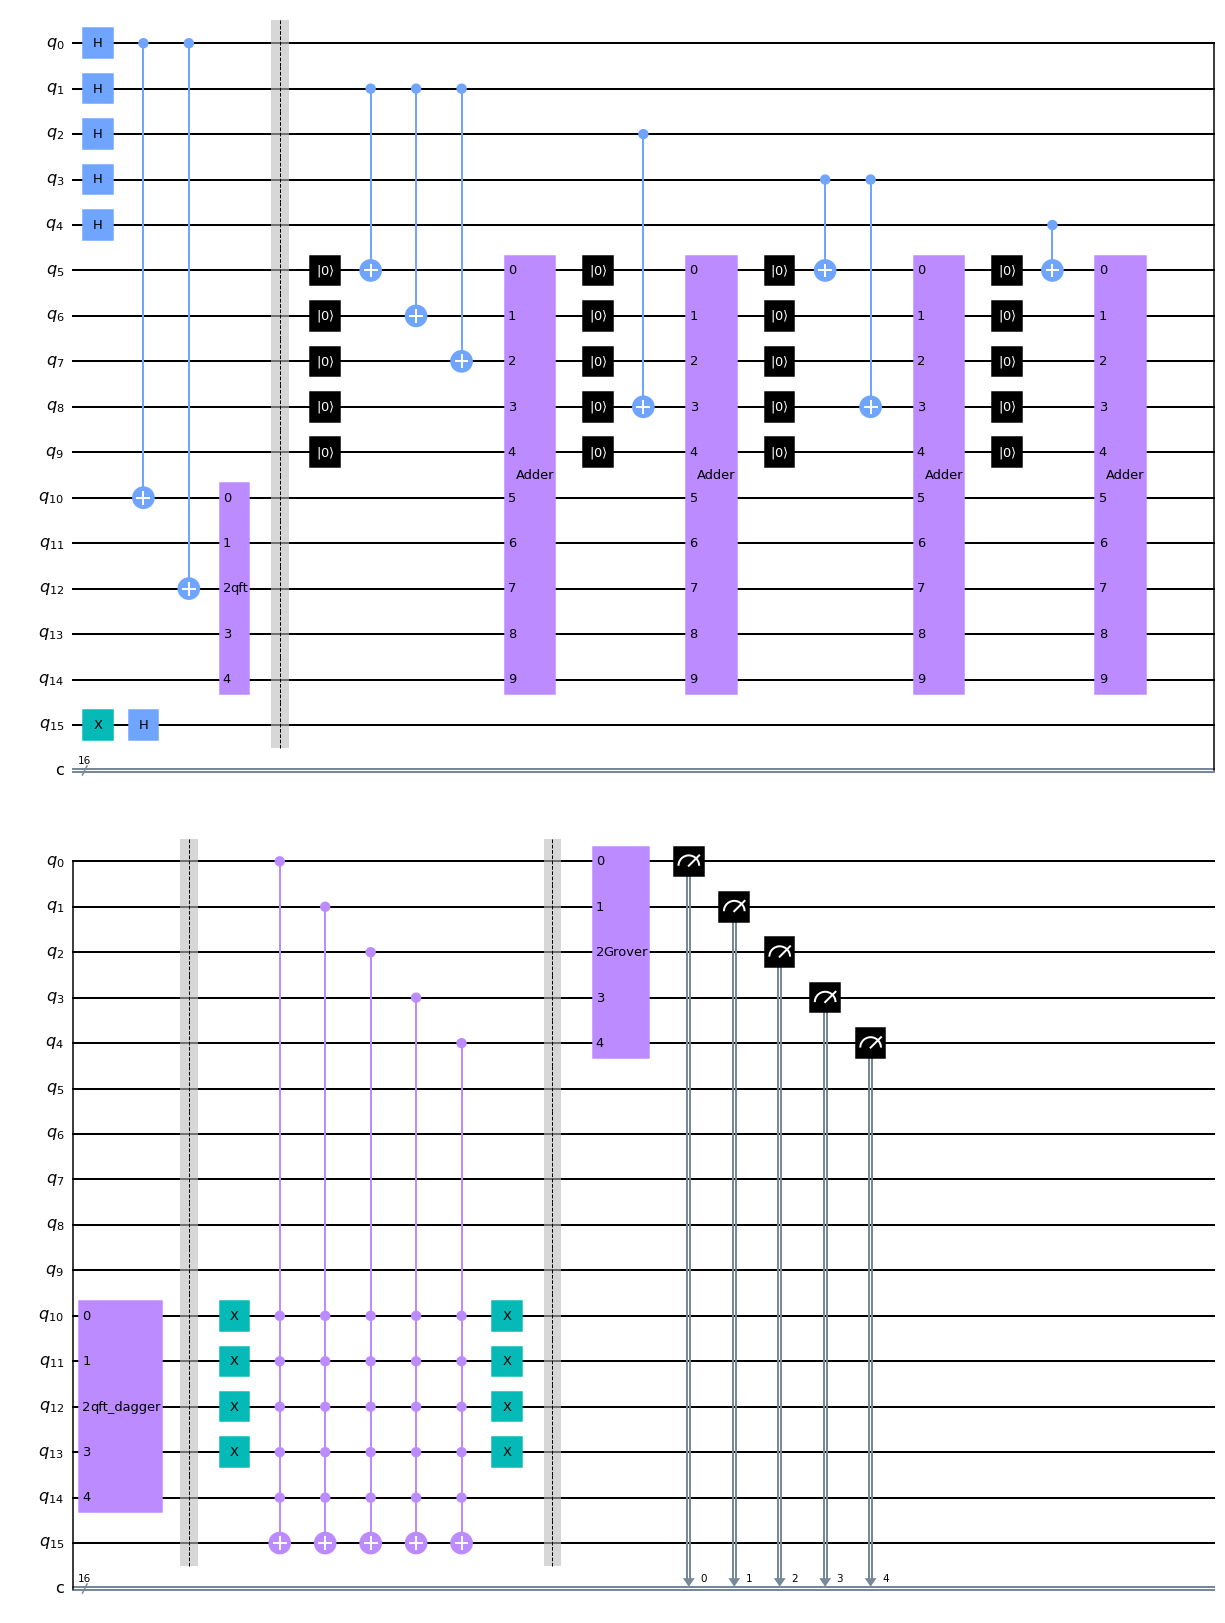

In [447]:
# then we need to apply the grover oracle and the grover operator to increase abs value of aplitudes to give higher prob for the search matching (sum = 16)
def grover_oracle(circuit) :
    # number in the 5 qubits we perform the additions should be 10000 (16)
    circuit.x([10, 11, 12, 13])
    circuit.mct([0, 10, 11, 12, 13, 14], 15)
    circuit.mct([1, 10, 11, 12, 13, 14], 15)
    circuit.mct([2, 10, 11, 12, 13, 14], 15)
    circuit.mct([3, 10, 11, 12, 13, 14], 15)
    circuit.mct([4, 10, 11, 12, 13, 14], 15)
    circuit.x([10, 11, 12, 13])

    circuit.barrier()


def grover_operator(nqubits):
    qc = QuantumCircuit(nqubits)

    # Apply transformation |s> -> |00..0> (H-gates)
    for qubit in range(nqubits):
        qc.h(qubit)
    
    # Apply transformation |00..0> -> |11..1> (X-gates)
    for qubit in range(nqubits):
        qc.x(qubit)
    
    # Do multi-controlled-Z gate
    qc.h(nqubits-1)
    qc.mct(list(range(nqubits-1)), nqubits-1)  # multi-controlled-toffoli
    qc.h(nqubits-1)
    
    # Apply transformation |11..1> -> |00..0>
    for qubit in range(nqubits):
        qc.x(qubit)
    
    # Apply transformation |00..0> -> |s>
    for qubit in range(nqubits):
        qc.h(qubit)
    
    # We will return the diffuser as a gate
    gate = qc.to_gate()
    gate.name = "Grover"
    return gate

grover_iterations = 1

for i in range(grover_iterations) :
    grover_oracle(circuit)
    circuit.append(grover_operator(5), range(5))

circuit.measure(range(5), range(5))

# circuit.measure(range(10, 15), range(10, 15))

%matplotlib inline
circuit.draw('mpl')

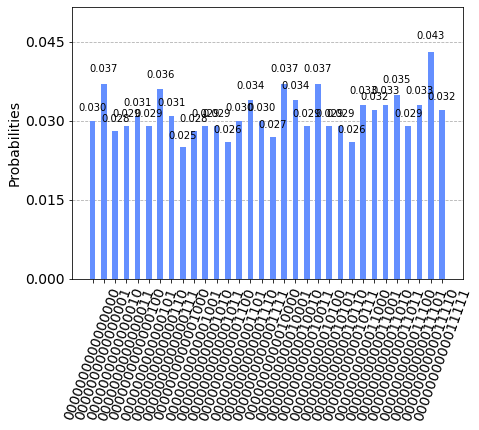

In [448]:
# then we simulate the circuit and see the results
simulator = simulator = Aer.get_backend('qasm_simulator')

result = execute(circuit, backend = simulator, shots = 1000).result()

counts = result.get_counts()

plot_histogram(counts)